In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from gensim.models import doc2vec
from collections import namedtuple
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpld3
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_pickle('data/gov_doc_df.pkl')

## Word 2 Vec

In [4]:
X = df['text_tokenize']
model = Word2Vec(X, size = 256,min_count=2) #keeping it to powers of 2

*We can see that democracy is for government what 'spirit' is to people, how poetic*

In [5]:
result = model.most_similar(positive = ['democracy','people'], negative=['government'], topn=5)
print(tabulate(result, floatfmt=".4f", headers=("Word", 'Similarity')))

Word       Similarity
-------  ------------
values         0.6067
dream          0.6006
spirit         0.5981
society        0.5975
minds          0.5950


*or that Japan is to America what 'Yemen' is to Syria - interesting to see rockets and bombing in the list*

In [6]:
result = model.most_similar(positive = ['japan', 'syria'], negative=['america'], topn=5)
print(tabulate(result, floatfmt=".4f", headers=("Word", 'Similarity')))

Word        Similarity
--------  ------------
yemen           0.8408
pakistan        0.7679
terror          0.7653
libyan          0.7612
iranian         0.7584


*one more example*

In [7]:
result = model.most_similar(positive = ['france', 'russia'], negative=['america'], topn=5)
print(tabulate(result, floatfmt=".4f", headers=("Word", 'Similarity')))

Word          Similarity
----------  ------------
indicted          0.8033
yemen             0.8019
guantanamo        0.7983
azerbaijan        0.7960
missiles          0.7956


In [8]:
#this one is not particularily useful to interesting to see the functionality of word2vec nonetheless
model.doesnt_match(["weapon","medicine","cure","disease"])

'weapon'

*What does Congress think of Russia *

In [9]:
result = model.most_similar("russia", topn=10)
print(tabulate(result, floatfmt=".4f", headers=("Word", 'Similarity')))

Word          Similarity
----------  ------------
communist         0.7833
colombia          0.7803
iran              0.7544
egypt             0.7456
diplomacy         0.7370
extremists        0.7362
terrorist         0.7330
chinas            0.7329
terrorists        0.7315
peaceful          0.7309


## Embedding Congress Members

In [10]:
#filter dataframe for non-protocol speech - reduced noise from our embedding
df = df[df['protocol'] == False]

In [11]:
def color_party(row):
    """Given a row that contains the part of the rep, presents the color code we'll assign """
    if row['party'] == '(D)':
        return 'b'
    elif row['party'] == '(R)':
        return 'r'
    else:
        return 'y' 

*create a series of lookups to later reference easily during diagram creation*

In [12]:
df['party_color'] = df.apply(color_party, axis=1)
#get distinct congress people
speakers = df["speaker"].drop_duplicates()
#create lookup table to map congress people
speaker_table = {speaker: n for n, speaker in enumerate(speakers)}
#also define inverse table for inverse lookup later
inv_speaker_table = {v: k for k, v in speaker_table.items()}
#also a table to look up party by color later
speaker_party = df[["speaker","party_color"]].drop_duplicates()
party_table = {s: p for s,p in zip(speaker_party.speaker,speaker_party.party_color)}
#also a table to look up if they are tea party
tea_party = df[["speaker","t_party"]].drop_duplicates()
tea_table = {s: t for s,t in zip(tea_party.speaker,tea_party.t_party)}

*Set up docs in the format of doc2vec*

In [13]:
docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
#this time we choose stemed vectors, since this is known to improve results of these models
for text, speaker in zip(df.text_stemmatize, df.speaker):
    tags = [speaker_table[speaker]]
    docs.append(analyzedDocument(text, tags))

#we're going to be pretty liberal with our min_count and risk unstable embeddings
d2v_model = doc2vec.Doc2Vec(docs, size = 256, min_count=3) 

*Do PCA and TSNE to flatten our mult-idimensional data*

In [14]:
#Laurens van der Maaten recommends going PCA prior to TSNE in order to remove noise and speed up computation
pca = PCA(n_components=50)
X = pca.fit_transform(d2v_model.docvecs)

#we'll need TSNE representations for both 2d and 3d exploration:
tsne2d = TSNE(n_components=2, random_state=5)
X2d = tsne2d.fit_transform(X) 

tsne3d = TSNE(n_components=3, random_state=5)
X3d = tsne3d.fit_transform(X) 

In [15]:
t_party_speakers = [k for k, v in tea_table.items() if v == True]
non_t_party_speakers = [k for k, v in tea_table.items() if v == False]

## Visualize Congressional Embedding in 3D Space

<IPython.core.display.Javascript object>


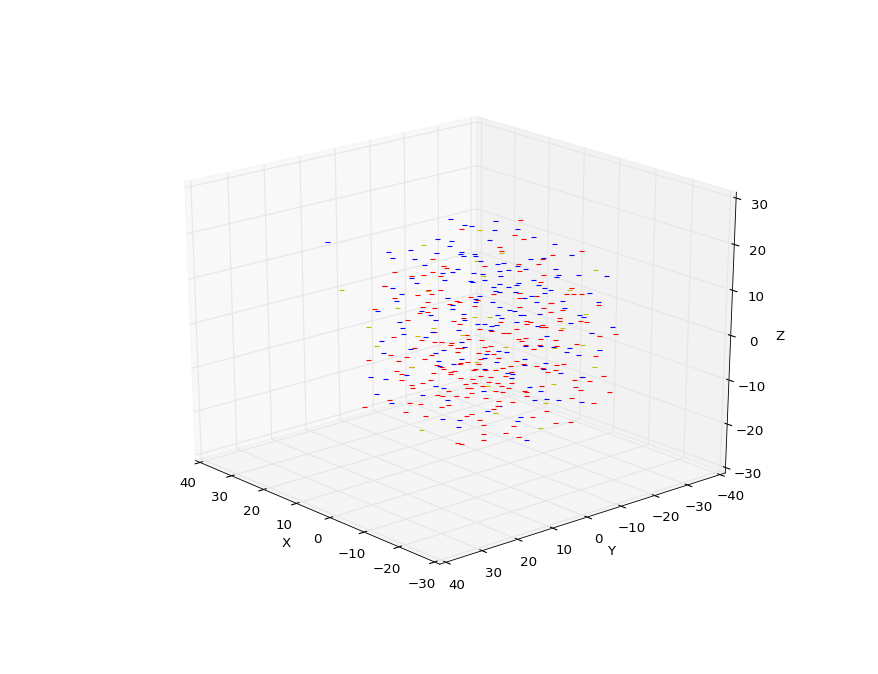

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n, v in enumerate(X3d):
    c = party_table[inv_speaker_table[n]]
    ax.scatter(v[0], v[1], v[2], c=c, marker=tea_table[inv_speaker_table[n]])    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

MUST RUN NOTEBOOK FOR GRAPH TO RENDER

*It's interesting to be able to interact with the cube, but 3D space is still difficult to engage with, let's take a look at 2D*

<IPython.core.display.Javascript object>


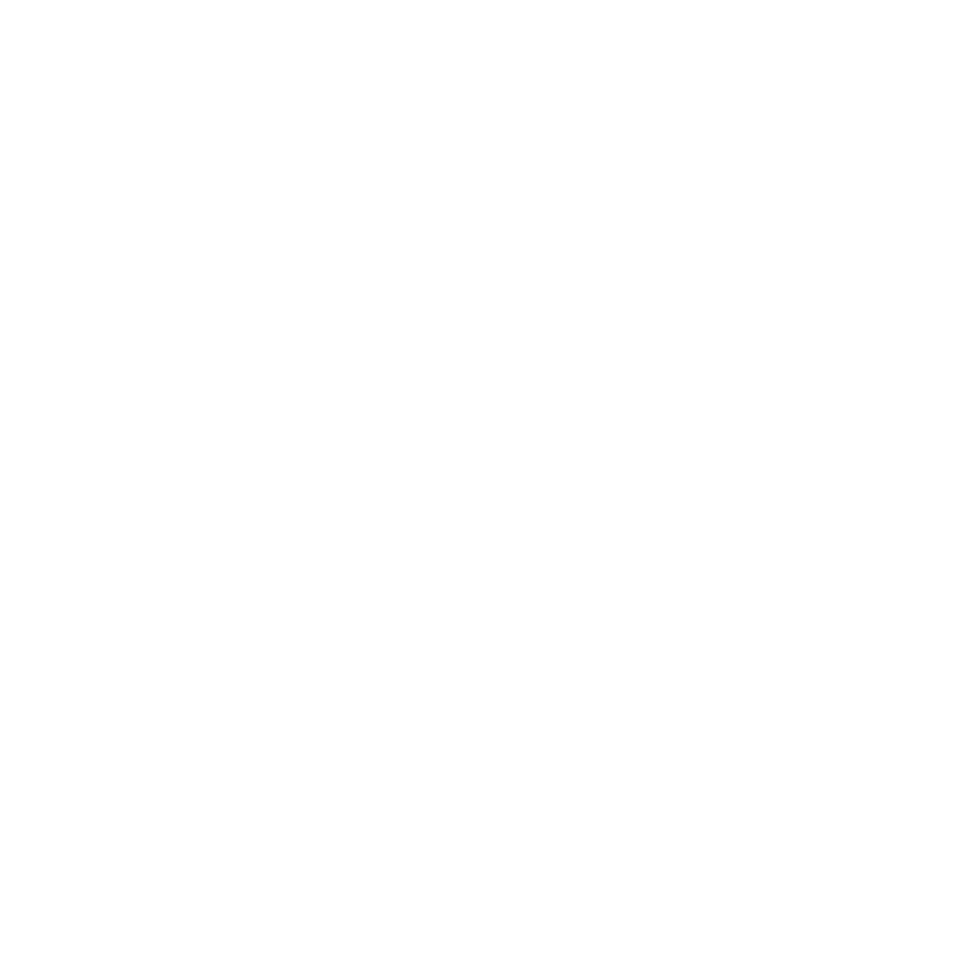

In [18]:
plt.rcParams['figure.figsize']=(12,12)
fig, ax = plt.subplots()


scatter_t = ax.scatter(X2d[[v for k,v in speaker_table.items() if k in set(t_party_speakers)],0],
                     X2d[[v for k,v in speaker_table.items() if k in set(t_party_speakers)],1],
                     c=[party_table[inv_speaker_table[v]] for k,v in speaker_table.items() if k in set(t_party_speakers)],
                     marker='^',
                     cmap=plt.cm.jet)

scatter = ax.scatter(X2d[[v for k,v in speaker_table.items() if k in set(non_t_party_speakers)],0],
                     X2d[[v for k,v in speaker_table.items() if k in set(non_t_party_speakers)],1],
                     c=[party_table[inv_speaker_table[v]] for k,v in speaker_table.items() if k in set(non_t_party_speakers)],
                     marker='o',
                     cmap=plt.cm.jet)

ax.grid(color='white', linestyle='solid')

ax.set_title("Embedding of 112th Congress", size=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')

labels_t = [inv_speaker_table[v] for k,v in speaker_table.items() if k in set(t_party_speakers)]
labels = [inv_speaker_table[v] for k,v in speaker_table.items() if k in set(non_t_party_speakers)]
tooltip1 = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
tooltip2 = mpld3.plugins.PointLabelTooltip(scatter_t, labels=labels_t)
mpld3.plugins.connect(fig, tooltip1, tooltip2)

mpld3.display()
#mpld3.show()
#mpld3.enable_notebook()

> *We can see our language embedding actuall form word offshoots for a small subset of republicans. Democrats are clustered in a Republican word sandwich, With Republican's fascinatingly falling into almost two different word clusters. This might have to do with the the pattern we saw earlier in the EDA section, where, on average, Republicans speak less, but a small long-tail tend to talk a lot.*